In [1]:

from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.utils import shuffle
data = datasets.load_breast_cancer()
from sklearn.preprocessing import StandardScaler

import jax.numpy as jnp
from jax import grad as fgrad
from jax import jit, vmap, jacfwd, jacrev, device_put
import numpy as np
from numpy.linalg import norm
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import grad
from scipy.integrate import solve_ivp
np.set_printoptions(suppress=True)
from matplotlib import pyplot as plt
import random
import jax

from copy import deepcopy

CUDA = torch.cuda.is_available()
mse = nn.MSELoss(reduction='none')
NUMERICAL_METHOD = 'RK45'

seed = 23

random.seed(seed)
# Set seed for NumPy
np.random.seed(seed)
# Set seed for PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
# Set seed for JAX
key = jax.random.PRNGKey(seed)

def select_n_points(data_X, data_y, n):
    # Check if n is even
    if n % 2 != 0:
        raise ValueError("n must be an even number to select equal points from both classes.")

    # Separate the data into two classes: +1 and -1
    class_pos = data_X[data_y == 1]  # Class +1
    class_neg = data_X[data_y == -1]  # Class -1

    # Check if enough points exist in both classes
    if len(class_pos) < n // 2 or len(class_neg) < n // 2:
        raise ValueError("Not enough data points in one or both classes to select n points.")

    # Randomly select n//2 points from each class
    selected_pos = class_pos[np.random.choice(len(class_pos), n // 2, replace=False)]
    selected_neg = class_neg[np.random.choice(len(class_neg), n // 2, replace=False)]

    # Combine the selected points and their labels
    selected_X = np.vstack((selected_pos, selected_neg))
    selected_y = np.hstack((np.ones(n // 2), -np.ones(n // 2)))

    # Shuffle the selected points and labels
    selected_X, selected_y = shuffle(selected_X, selected_y, random_state=42)

    return selected_X, selected_y

In [2]:
X = data.data 
y = data.target
feature_names = data.feature_names

X = pd.DataFrame(X, columns=feature_names) 
# Select only the desired features
data_X = X[["mean radius","mean concave points","worst radius","mean perimeter","worst concave points","mean area","worst area","mean concavity","mean texture","worst texture","mean smoothness","worst smoothness","mean compactness","worst compactness","mean symmetry", "worst symmetry"]].to_numpy()

# Encode y to be +1 and -1
le = LabelEncoder()
data_y = le.fit_transform(y)
data_y[data_y == 0] = -1  # Replace 0 with -1

[Text(0.5, 0, 'mean radius'), Text(0, 0.5, 'mean concave points')]

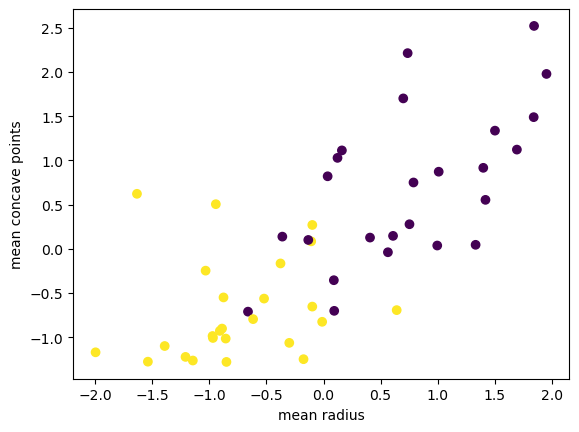

In [3]:
n = 50
selected_X, selected_y = select_n_points(data_X, data_y, n)
scaler = StandardScaler()
selected_X = scaler.fit_transform(selected_X)
_, ax = plt.subplots()
scatter = ax.scatter(selected_X[:, 0], selected_X[:, 1], c=selected_y)
ax.set(xlabel='mean radius', ylabel='mean concave points')

In [4]:
# Define the plotting function
def plot_svm_decision_boundary(X, y, w, b, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Malignant')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Benign')

    # Plot decision boundary
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Use only the selected features for the decision boundary
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = np.dot(grid, w[[feature_x_idx, feature_y_idx]]) + b
    Z = Z.reshape(xx.shape)
    
    plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])
    
    plt.xlabel(f'mean radius')
    plt.ylabel(f'mean concave points')
    plt.legend()
    #plt.title('Soft Margin SVM Decision Boundary')
    plt.show()
    
# Define the modified plotting function to plot two decision boundaries
def plot_svm_decision_boundary_confrontation(X, y, w_1, b_1, w_2, b_2, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Malignant')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Benign')

    # Create mesh grid for decision boundaries
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # First model's decision boundary (Ground Truth) in orange with highlight effect (thicker and transparent)
    Z1 = np.dot(grid, w_1[[feature_x_idx, feature_y_idx]]) + b_1
    Z1 = Z1.reshape(xx.shape)
    ground_truth = plt.contour(xx, yy, Z1, colors='purple', levels=[0], alpha=0.3, linewidths=5, linestyles=['-'])
    plt.contour(xx, yy, Z1, colors='purple', levels=[-1, 1], alpha=0.3, linewidths=3, linestyles=['--'])
    
    # Second model's decision boundary (ODE Solution) in purple
    Z2 = np.dot(grid, w_2[[feature_x_idx, feature_y_idx]]) + b_2
    Z2 = Z2.reshape(xx.shape)
    ode_solution = plt.contour(xx, yy, Z2, colors='green', levels=[0], alpha=0.8, linewidths=2, linestyles=['-'])
    plt.contour(xx, yy, Z2, colors='green', levels=[-1, 1], alpha=0.8, linewidths=1.5, linestyles=['--'])
    
    # Add the two main lines to the legend
    h1, _ = ground_truth.legend_elements()
    h2, _ = ode_solution.legend_elements()
    legend_elements = [h1[0], h2[0], 
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10)]
    legend_labels = ['CVX Solution', 'ODE Solution', 'Malignant', 'Benign']
    plt.legend(legend_elements, legend_labels, loc='upper right')
    
    # Add labels, title, and show the plot
    plt.xlabel(f'mean radius')
    plt.ylabel(f'mean concave points')
    #plt.title('SVM Decision Boundaries')
    plt.show()
    
def plot_svm_decision_boundary_confrontation_PINN(X, y, w_1, b_1, w_2, b_2, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Malignant')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Benign')

    # Create mesh grid for decision boundaries
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # First model's decision boundary (Ground Truth) in orange with highlight effect (thicker and transparent)
    Z1 = np.dot(grid, w_1[[feature_x_idx, feature_y_idx]]) + b_1
    Z1 = Z1.reshape(xx.shape)
    ground_truth = plt.contour(xx, yy, Z1, colors='purple', levels=[0], alpha=0.3, linewidths=5, linestyles=['-'])
    plt.contour(xx, yy, Z1, colors='purple', levels=[-1, 1], alpha=0.3, linewidths=3, linestyles=['--'])
    
    # Second model's decision boundary (ODE Solution) in purple
    Z2 = np.dot(grid, w_2[[feature_x_idx, feature_y_idx]]) + b_2
    Z2 = Z2.reshape(xx.shape)
    ode_solution = plt.contour(xx, yy, Z2, colors='green', levels=[0], alpha=0.8, linewidths=2, linestyles=['-'])
    plt.contour(xx, yy, Z2, colors='green', levels=[-1, 1], alpha=0.8, linewidths=1.5, linestyles=['--'])
    
    # Add the two main lines to the legend
    h1, _ = ground_truth.legend_elements()
    h2, _ = ode_solution.legend_elements()
    legend_elements = [h1[0], h2[0], 
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10)]
    legend_labels = ['ODE Solution', 'PINN Solution', 'Malignant', 'Benign']
    plt.legend(legend_elements, legend_labels, loc='upper right')
    
    # Add labels, title, and show the plot
    plt.xlabel(f'mean radius')
    plt.ylabel(f'mean concave points')
    #plt.title('SVM Decision Boundaries')
    plt.show()

In [5]:
def adjust_label_positions(positions, min_distance=0.02):
    """Adjust vertical positions of labels to avoid overlap."""
    sorted_positions = sorted(enumerate(positions), key=lambda x: x[1])
    adjusted_positions = positions.copy()
    
    for i in range(1, len(sorted_positions)):
        curr_idx, curr_pos = sorted_positions[i]
        prev_idx, prev_pos = sorted_positions[i-1]
        
        if curr_pos - prev_pos < min_distance:
            adjusted_positions[curr_idx] = prev_pos + min_distance
    
    return adjusted_positions

def plot_ode_system(t_values, y_values):
    plt.figure(figsize=(8, 6))
    # Enable LaTeX rendering
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Plot each line and prepare label information
    labels = [f'w_{i}' for i in range(1,3)] + ['b']
    colors = plt.cm.rainbow(np.linspace(0, 1, len(labels)))
    label_positions = []

    for i, (label, color) in enumerate(zip(labels, colors)):
        line = plt.plot(t_values, y_values[i, :], label=label, color=color)[0]
        label_positions.append(y_values[i, -1])

    # Adjust label positions
    y_min, y_max = np.min(y_values), np.max(y_values)
    y_range = y_max - y_min
    min_distance = 0.02 * y_range  # 2% of y-range as minimum distance
    adjusted_positions = adjust_label_positions(label_positions, min_distance)

    # Add adjusted labels with increased font size and space
    fontsize = 14  # Adjust the font size here
    x_offset = 1  # Space to move the label away from the line
    
    for i, (label, color, position) in enumerate(zip(labels[:3], colors[:3], adjusted_positions[:3])):
        math_label = f"${label}$"  # Add space with LaTeX's \quad
        x_end = t_values[-1]
        plt.text(x_end + x_offset, position, f' {math_label}', verticalalignment='center', 
                 horizontalalignment='left', color=color, fontsize=fontsize)

    plt.xlabel('Time', fontsize=fontsize)
    plt.ylabel('y(t)', fontsize=fontsize)
    plt.title('ODE System Solution', fontsize=fontsize)
    plt.grid(False)

    # Adjust the plot limits to make room for labels
    plt.xlim(t_values[0], t_values[-1] * 1.1)  # Extend x-axis by 10%
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)  # Extend y-axis by 10% on both ends

    plt.tight_layout()
    plt.show()

In [6]:
def hyperplane_similarity(w, b, w_opt, b_opt, alpha=0.5, beta=0.5):
    """
    Computes a metric to measure the similarity between two hyperplanes defined by (w, b) and (w_opt, b_opt).
    
    Parameters:
    - w (np.ndarray): Normal vector of the first hyperplane.
    - b (float): Offset of the first hyperplane.
    - w_opt (np.ndarray): Normal vector of the optimal hyperplane.
    - b_opt (float): Offset of the optimal hyperplane.
    - alpha (float): Weight for the angular difference metric. Default is 0.5.
    - beta (float): Weight for the offset difference metric. Default is 0.5.
    
    Returns:
    - float: Combined metric value. Closer to 0 indicates more similar hyperplanes.
    """
    # Normalize vectors for angle computation
    norm_w = np.linalg.norm(w)
    norm_w_opt = np.linalg.norm(w_opt)
    
    # Handle edge cases for zero vectors
    if norm_w == 0 or norm_w_opt == 0:
        raise ValueError("The normal vector of a hyperplane cannot be a zero vector.")
    
    # Compute cosine similarity and angle metric
    cos_theta = np.dot(w, w_opt) / (norm_w * norm_w_opt)
    angle_metric = 1 - cos_theta
    
    # Normalize vectors to unit length for offset comparison
    w_unit = w / norm_w
    w_opt_unit = w_opt / norm_w_opt
    
    # Compute the offset difference metric
    offset_diff = abs(b / norm_w - b_opt / norm_w_opt)
    offset_metric = offset_diff / max(abs(b / norm_w), abs(b_opt / norm_w_opt), 1)
    
    # Combine metrics
    combined_metric = alpha * angle_metric + beta * offset_metric
    return combined_metric

# CVX

Time: 0.02030348777770996
Optimal objective value: 1.8965921239901276
SCS solver iterations: 300
SCS solve time: 0.003900315
SCS setup time: 0.0023920530000000003
Optimal w:  [-0.24493117 -0.19903005 -0.45051123 -0.19661894 -0.45879994 -0.33194222
 -0.49425433 -0.42800951 -0.14592342 -0.64398588  0.17535742 -1.37022309
  0.53850334 -0.01144696  0.12007946 -0.23457824]
Optimal b:  [-0.55994563]
Dual variables (Lagrange multipliers): [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.          0.          0.          0.          1.17816555
  0.07556303  0.          0.          0.          0.          0.21371499
 -0.          0.96826391  0.          0.          0.          0.64835129
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.09002686
  0.          0.          0.          0.18995261  0.42913543  0.
  0.        

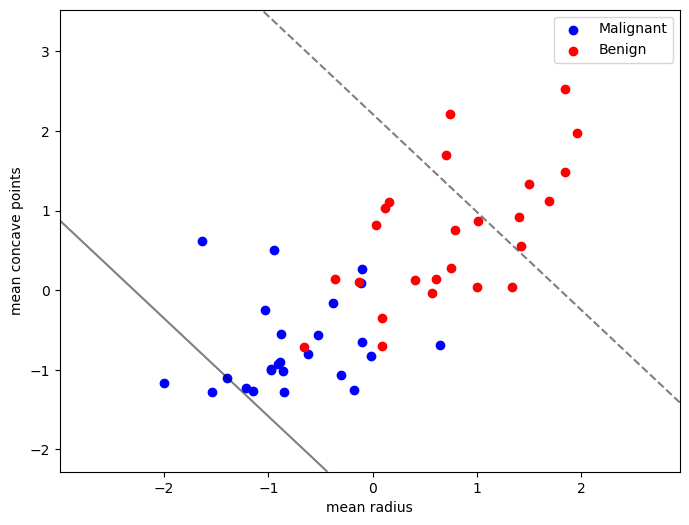

In [7]:
import cvxpy as cp
import numpy as np
import time

C = 10

num_features = selected_X.shape[1]

w = cp.Variable(num_features)
b = cp.Variable(1)
xi = cp.Variable(selected_y.shape[0])

objective = cp.Minimize((1/2)*cp.norm(w, 2)**2 + C * cp.sum(xi))

constraints = [
    cp.multiply(selected_y, cp.matmul(selected_X, w) + b) >= 1 - xi,
    xi >= 0
]

problem = cp.Problem(objective, constraints)

t0 = time.time()
problem.solve(solver='SCS')
solve_time = time.time() - t0

# Get solver stats
solver_stats = problem.solver_stats
print('Time:', solve_time)
print('Optimal objective value:', problem.value)
print('SCS solver iterations:', solver_stats.num_iters)
print('SCS solve time:', solver_stats.solve_time)
print('SCS setup time:', solver_stats.setup_time)

# Get the values of the variables
print('Optimal w: ', w.value)
print('Optimal b: ', b.value)

# Get the dual variables
dual_variables = constraints[0].dual_value
print('Dual variables (Lagrange multipliers):', dual_variables)

g_1 = [-selected_y[i] * (w.value @ selected_X[i] + b.value) + 1 for i in range(selected_y.shape[0])]
g_2 = [np.array([-xi.value[i]]) for i in range(selected_y.shape[0])]
g_SCS = jnp.array(g_1 + g_2).flatten()
print('Constraints:', g_SCS)

# Plotting
plot_svm_decision_boundary(selected_X, selected_y, w.value, b.value, 0, 1)

wb_cvx = np.concatenate([w.value, b.value])

# ODE

In [8]:
nw = selected_X.shape[1]
nb = 1
nxi = selected_y.shape[0]
nx = nw + nb + nxi
nu = selected_X.shape[0] * 2
NY = nx+nu

def f(x):
    w = x[:nw]
    b = x[nw]
    xi = x[nw+nb:]
    
    output = (1/2) * jnp.linalg.norm(w, 2)**2 + C * jnp.sum(xi)
    return output

def g(x):
    w = x[:nw]
    b = x[nw]
    xi = x[nw+nb:]
    
    g_1 = [-selected_y[i] * (w @ selected_X[i] + b) + 1 - xi[i] for i in range(selected_y.shape[0])]
    g_2 = [- xi[i] for i in range(selected_y.shape[0])]
    output = jnp.array(g_1 + g_2)
    return output

df = fgrad(f) # jacobian of f
dg = jacrev(g) # jacobian of g

def P(xu): # projection mapping
    return xu

def ODE(t, xu):
    x, u = xu[:nx].reshape((nx, )), xu[nx:].reshape((nu, ))

    dx = df(x) + dg(x).T@jnp.clip(u+g(x), a_min=0)
    dx = -dx
    du = -u + jnp.clip(u+g(x), a_min=0)
    du = 0.5*du
    dxu = jnp.concatenate([dx, du], axis=0)
    return dxu

ODE = jit(ODE)


In [9]:

def evalutation(xu): # metric OuC(x_pred): check if inisde feasable region and return the objective value
    "return  f(x),    if g(x)<=0, f(x)=np.inf, if g(x)>0 "
    x, u= xu[:nx], xu[nx:]
    if (g(x)<=0.01).all():
        obj = f(x)
        #print('g(x) values:', g(x))
    else:
        obj = np.inf
        #print('g(x) values:', g(x))
    return obj

def evaluation_plus(xu):
    x, u= xu[:nx], xu[nx:]
    lim = None
    if (g(x)<=0.001).all():
        lim = 0.001
    elif (g(x)<=0.01).all():
        lim = 0.01
    elif (g(x)<=0.1).all():
        lim = 0.1
    elif (g(x)<=1).all():
        lim = 1
    return f(x), lim


In [10]:
def solve_ODE(xuv0, T):
    t0 = time.time()
    sol = solve_ivp(ODE, [0., T], xuv0, method=NUMERICAL_METHOD)
    solve_time = time.time() - t0
    print('Time:', solve_time)
    result = P(sol.y[:, -1])
    
    obj, lim = evaluation_plus(result)
    print("objective:", obj, "lim:", lim)
    
    print("objective:", obj)
    print("w: ", result[:nw], "b: ", result[nw])
    wb_ode = result[:nw+nb]
    similarity = hyperplane_similarity(result[:nw], result[nw], wb_cvx[:nw], wb_cvx[nw])
    print("hyperplane similarity:", similarity)
    print("Dual variables (alpha):", result[:nx])
    print("Constraints:",g(result[:nx]))
    
    return sol, result, obj, lim, similarity

# PINN

In [11]:
class FNN(nn.Module):
    def __init__(self, y0):
        self.y0 = torch.tensor(y0, dtype=torch.float)
        if CUDA:
            self.y0 = self.y0.cuda()
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(1, NEURONS).cuda()
        self.linearL = []
        for _ in range(LAYERS-1):
            self.linearL.append(nn.Linear(NEURONS, NEURONS).cuda())
        self.linear2 = nn.Linear(NEURONS, NY).cuda()

    def forward(self, x):
        t = x.cuda()
        x = torch.tanh(self.linear1(x))
        for i in range(LAYERS-1):
            x = torch.tanh(self.linearL[i](x))
        x = self.linear2(x)
        x = self.y0 + (1 - torch.exp(-(t-0)))*x
        return x


class NN_NOP:
    def __init__(self, y0, time_range, P, ODE, C_epsilon): # P: projection mapping, ODE, C_epsilon: OuC metric
        self.y0 = np.array(y0)
        self.time_range = time_range # [0, 10]
        self.T = time_range[-1] # T=10
        self.P = P
        self.ODE = ODE
        self.C_epsilon = C_epsilon
        self.vODE = vmap(ODE, in_axes=(0, 0), out_axes=0)
        #self.numerical_method() # solve analyicallly the ODE

    def numerical_method(self):
        sol = solve_ivp(self.ODE, self.time_range, self.y0, method=NUMERICAL_METHOD)
        self.y_T_ODE = sol.y[:, -1] # get last value of the solution
        self.y_T_ODE = self.P(self.y_T_ODE) # project it
        self.y_T_ODE = np.array(self.y_T_ODE)
        self.epsilon_ODE = self.C_epsilon(self.y_T_ODE) # calculate OuC (f(x))

    def NN_method(self, weights=None, t_L=None):
        """
        train the nn, store the following four

        L_loss:  list, loss of batch during training
        L_epsilon: list, epsilon_best during training
        L_y_T: list, yT during training
        net_best:  the best neural network model during training
        """
        net = FNN(self.y0)
        if weights is not None:
            net.load_state_dict(weights.state_dict())
        if CUDA:
            net = net.cuda()
            
        optimizer = Adam(net.parameters(), lr=LR) # ========> 0.001 not looks good
        i = 0
        L_loss = []
        L_epsilon = []
        L_epsilon_curr = []
        L_y_T = []
        L_y_T_curr = []
        #L_y_iterations = []
        t0 = time.time()
        while True:
            # Update, L_epsilon, L_yT, net_best
            T = self.T*torch.ones((1, 1), dtype=torch.float)
            if CUDA:
                T = T.cuda()
            y_T = self.P_multiple(T, net) # get the output of the nn at T (last time)
            L_y_T_curr.append(y_T)

            epsilon_current = self.C_epsilon(y_T) # calculate OuC (f(x))
            L_epsilon_curr.append(epsilon_current)
            if i==0: # if first iteration
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
                #L_y_iterations.append(self.y_iteration(net_best))
            # if i==10:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==20:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==ITERATIONS-1:
            #L_y_iterations.append(self.y_iteration(net_best)) # store the output of the best nn across the time
            if epsilon_current < epsilon_best:
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
            L_epsilon.append(epsilon_best) # store the best OuC
            L_y_T.append(y_T_best) # store the best output of the nn at T

            # TRAIN MODEL
            # Prepare input t, torch.tensor (NBATCH, 1)
            if t_L is not None:
                t = t_L[i]
            else:
                t = np.random.uniform(0, self.T, (NBATCH, 1))
            t = torch.tensor(t, dtype=torch.float, requires_grad=True)
            if CUDA:
                t = t.cuda()
            # Learning, L_loss
            loss = self.loss_compute(t, net)
            loss.backward()
            L_loss.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()
            # Monitor
            if i%100==0:
            # if i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                #print(f'T: {self.T}, y_T_ODE: {self.y_T_ODE.round(4)}, epsilon_ODE: {self.epsilon_ODE :.4f},  Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}, ||y_T_ODE-y_T_best||_2: {y_T_error :.4f}')
                #print(f'T: {self.T}, Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}')
                pass
            i = i+1
            
            torch.cuda.empty_cache()
            
            if i >= 1000 and all(x < 0.01 for x in L_loss[-5:]):
                break
            
            if i==ITERATIONS:
                break

        curr_net = deepcopy(net)
        return L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, curr_net, L_loss, time.time()-t0, i

    def loss_compute(self, t, net):
        # nn output xu, torch.tensor (NBATCH, nxu)
        y = net(t)

        # => Get ODE derivatives
        # True dxu, torch.tensor (NBATCH, nxu)
        t_cpu = t.cpu().detach().numpy()
        y_cpu = y[:, :].cpu().detach().numpy()
        dy = self.vODE(t_cpu, y_cpu)
        dy = np.array(dy)
        
        dy = torch.tensor(dy, dtype=torch.float)
        if CUDA:
            dy = dy.cuda()

        # => Get NN derivatives (autograd)
        # Predicted pdxu, torch.tensor (NBATCH, nxu)
        pdy = []
        for j in range(NY): # for all outputs node (for all variables)
            # y[:, [j]]: outputs of the nn for the j-th variable (all t of the batch), t: inputs of the nn, grad_outputs: scale the gradients to facilitate the compuation of the jacobian, Craete_graph: to compute higer order derivatives
            pdyi = grad(y[:, [j]], t, grad_outputs=torch.ones_like(y[:, [j]]), create_graph=True)[0] # torch autograd shape [NBATCH, 1]
            pdy.append(pdyi)
        pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]
        #pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]

        # Compute loss, torch.tensor a float
        dynamics_loss = mse(dy, pdy) # [NBATCH, NY]
        dynamics_loss = torch.sum(dynamics_loss, axis=1) # [NBATCH]
        dynamics_loss = torch.exp(-WEIGTHING*(t / T).detach().reshape((-1, )))*dynamics_loss  # proprity smaller t
        dynamics_loss = torch.mean(dynamics_loss, axis=0)
        
        return dynamics_loss

    def P_multiple(self, t, net): # get the projection of the output of the nn (for multiple t)
        y = net(t)
        y = y.reshape((-1, )).cpu().detach().numpy()
        output = self.P(y)
        output = np.array(output)
        return output

    def y_iteration(self, net): # get the ODE system estiamtion across the time
        # For L_y
        t = torch.arange(0, self.T, 0.1).reshape((-1, 1))
        if CUDA:
            t = t.cuda()
        y = [self.P_multiple(t[i].reshape((1,1)), net) for i in range(t.shape[0])]
        y = torch.tensor(np.array(y)).cpu().detach().numpy()

        return y # [T, NY]

# Runs

In [12]:
def iteration(ip):
    xu0 = jnp.array(ip)
    y0 = ip
    
    # ODE Solution
    sol, result, obj, lim, similarity = solve_ODE(xu0, T)
    
    if lim == None:
        print('>>> Infeasible')
    else:
        print('>>> Feasible with epsilon:', lim, 'objective:', obj)

    print("hyperplane similarity:", similarity)
    if similarity < 0.01:
        print('>>> ODE Solution is accurate, last iteration')
        lastIter = True
    else:
        lastIter = False
        
    t_values = sol.t
    y_values = sol.y

    w_ode = result[:data_X.shape[1]]
    b_ode = result[data_X.shape[1]]

    plot_ode_system(t_values, y_values)

    plot_svm_decision_boundary_confrontation(selected_X, selected_y, w.value, b.value, w_ode, b_ode, 0, 1)
    
    example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
    L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, net_curr, L_loss, t, n_iter = example.NN_method() # train
    print('epsilon:', L_epsilon[-1], 'time:', t, 'iterations:', n_iter)
    
    # ------------ NN plots ------------ 
    plt.plot(L_epsilon, marker='o', linestyle='-', label='OuC metric best', markersize=1)
    plt.plot(L_epsilon_curr, marker='o', linestyle='-', label='OuC metric current', markersize=1)
    plt.xlabel('iteration')
    plt.ylabel('OuC metric')
    #plt.title(f'l={res_1["layers"]}, n={res_1["neurons"]}, lr={res_1["lr"]}')
    plt.legend()
    plt.grid(False)
    #plt.set_ylim(y_min, y_max)
    plt.xlim(0, ITERATIONS)

    plt.tight_layout()
    # Show the plot
    plt.show()
    
    print('Last losses:', L_loss[-10:])

    plt.plot(L_loss, label='Loss')
    plt.xlabel('iteration')
    plt.ylabel('Loss')
    #plt.title(f'l={res_1["layers"]}, n={res_1["neurons"]}, lr={res_1["lr"]}')
    plt.legend()
    plt.grid(False)
    #plt.set_ylim(y_min, y_max)
    plt.xlim(0, ITERATIONS)
    plt.tight_layout()
    # Show the plot
    plt.show()
    
    if n_iter != ITERATIONS and lastIter:
        print('>>> NN Solution is accurate, last iteration')
        net = net_curr
        lastIter = True
    else:
        lastIter = False
        net = net_curr
    
    res = net(torch.tensor([T]).cuda()).cpu().detach().numpy()
    plot_svm_decision_boundary_confrontation_PINN(selected_X, selected_y, w_ode, b_ode, res[:data_X.shape[1]], res[data_X.shape[1]], 0, 1)
    print('Variables:', res[:nx])
    print('Constraints:', g(res[:nx]))
    
    pinn_obj, lim_pin = evaluation_plus(res)
    
    print("objective pinn:", pinn_obj, "epsion pinn:", lim_pin)
    
    print("w: ", res[:nw], "b: ", res[nw])

    similarity_pinn = hyperplane_similarity(res[:nw], res[nw], wb_cvx[:nw], wb_cvx[nw])
    print("PINN hyperplane similarity:", similarity_pinn)
    
    return res, pinn_obj, lastIter

In [13]:
NBATCH = 512
WEIGTHING = 1
LAYERS = 2
NEURONS = 100
LR = 0.001
T = 20.0

>>>> ITERATION: 1


Time: 8.358800172805786


objective: 1.6728086 lim: 0.1
objective: 1.6728086
w:  [-0.24990854 -0.1955313  -0.45749051 -0.20061023 -0.48407511 -0.33704043
 -0.50110668 -0.42771298 -0.14128944 -0.65416217  0.18720821 -1.40614926
  0.55494958 -0.01018921  0.14421221 -0.25033246] b:  -0.5654701026018265
hyperplane similarity: 0.002171838131804771
Dual variables (alpha): [-0.24990854 -0.1955313  -0.45749051 -0.20061023 -0.48407511 -0.33704043
 -0.50110668 -0.42771298 -0.14128944 -0.65416217  0.18720821 -1.40614926
  0.55494958 -0.01018921  0.14421221 -0.25033246 -0.5654701   0.00049353
  0.00049352  0.0004933   0.00049319  0.00009278  0.00049349  0.00049298
  0.0004935   0.0004907   0.00049353  0.00049369  0.00049355  0.00049349
  0.00049352  0.00049161  0.00049384  0.00001111 -0.02167272 -0.00016193
  0.00049377  0.00049387  0.00049353  0.00038164  0.00019375  0.00049359
 -0.01314751  0.00049291  0.00030172  0.00039344 -0.00201149  0.00049349
  0.00049387  0.00049199  0.00049348  0.00049348  0.00049392  0.00049105


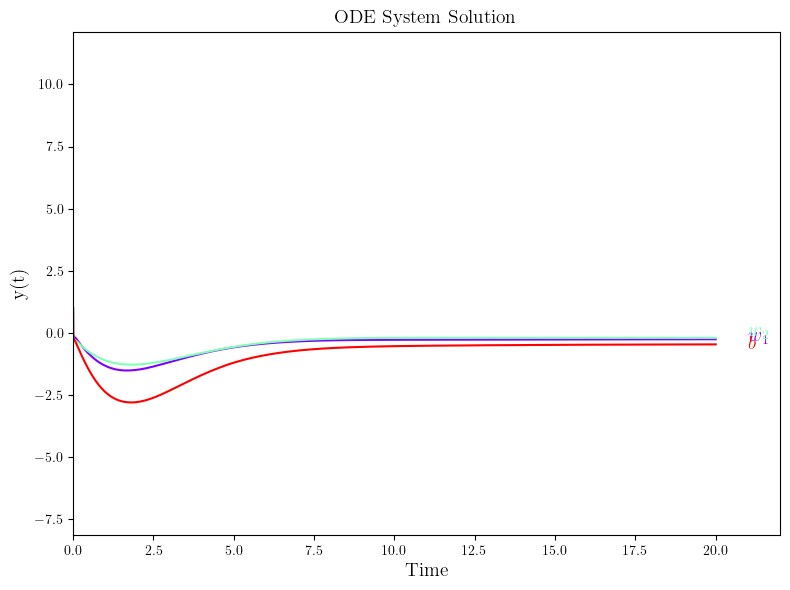

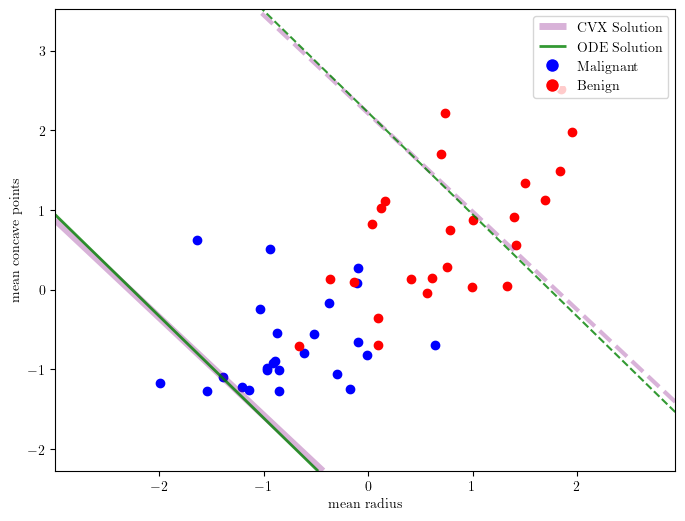

epsilon: 1174.7036 time: 816.2740688323975 iterations: 2000


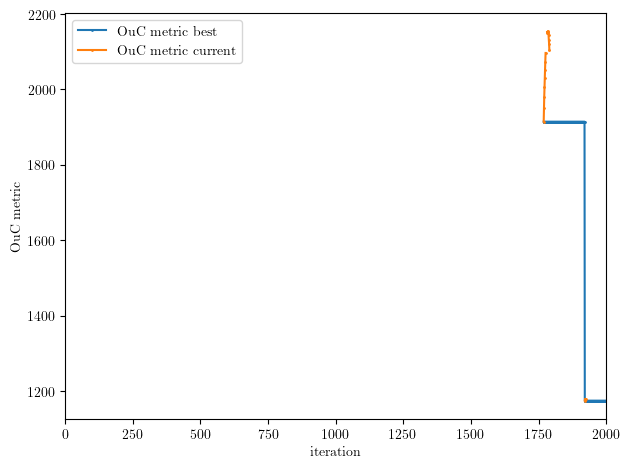

Last losses: [1546.8350830078125, 303.68133544921875, 281.82879638671875, 118.31443786621094, 156.17770385742188, 1512.677001953125, 1173.031005859375, 3572.818359375, 236.9664764404297, 269.34527587890625]


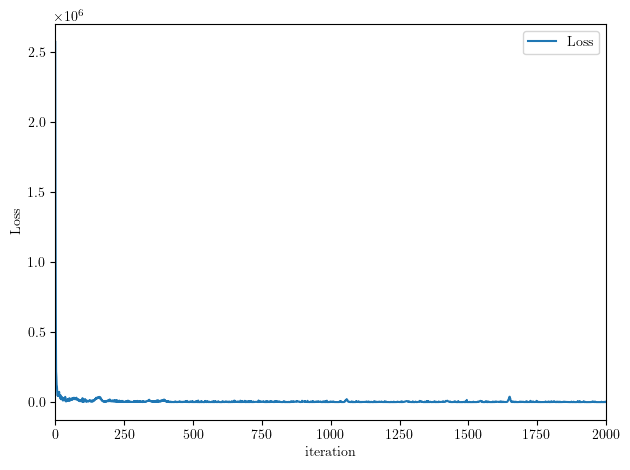

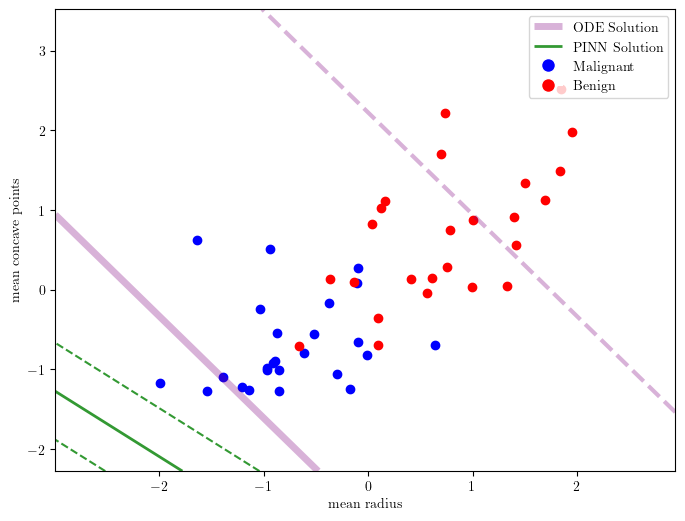

Variables: [-1.3538084  -1.6449447  -2.3579745  -1.2974865  -2.9066815  -1.3957891
 -2.2588015  -1.6150937  -1.8816829  -3.6137977   0.05536503 -6.426346
  0.40832716 -0.8017311   1.0370003  -1.9672289  -6.1586466   0.9679246
  0.8246467   0.8894985   0.94615686  0.58151     0.9165096   0.88518053
  0.9383621   1.0384077   0.96592927  0.43636233  0.94547224  0.705981
  0.6805961   0.3700698   0.04115596  0.47391936 -0.962408    1.0642171
  0.59428966  1.9085109   0.9782773  -0.23808205  0.19554707  0.9639449
 -0.53198886  0.74953914  0.87717795  1.5711122  -0.9922962   0.92461157
  0.27722773  0.48987228  0.8705218   0.9643307   0.95249677  0.5746635
  0.94610053  0.9804925   1.3977168   0.43916297 -0.29018426  1.8441226
  1.2139691   1.4592003  -0.34002757  0.16024993  0.5481356   0.92132485
  0.9519806 ]
Constraints: [-16.280167   -28.0969     -30.652597   -36.07923     -4.406673
 -31.564316   -37.636097   -35.900776   -12.29258    -24.21284
 -18.236172   -29.5262     -23.81842    -1

Time: 1.6619374752044678
objective: 2.0093727 lim: 0.01
objective: 2.0093727
w:  [-0.24461521 -0.20354937 -0.44505788 -0.19682748 -0.47133449 -0.33226902
 -0.48970399 -0.40559743 -0.14496425 -0.64083226  0.17136305 -1.35714673
  0.52978055 -0.00229308  0.11645522 -0.2323366 ] b:  -0.5558814957624885
hyperplane similarity: 0.0002904377319671303
Dual variables (alpha): [-0.24461521 -0.20354937 -0.44505788 -0.19682748 -0.47133449 -0.33226902
 -0.48970399 -0.40559743 -0.14496425 -0.64083226  0.17136305 -1.35714673
  0.52978055 -0.00229308  0.11645522 -0.2323366  -0.5558815  -0.00007308
 -0.00003334 -0.00007365 -0.00007567  0.00106812 -0.00007728 -0.00007648
 -0.0000751  -0.00009959 -0.00007433 -0.00006911 -0.00007503 -0.0000753
 -0.00008001 -0.00021651 -0.00009011  0.00040022  0.00515637 -0.0000218
 -0.00004654 -0.00005003 -0.00007215 -0.00012045 -0.00042409 -0.00007273
  0.00682592 -0.0000796   0.00081575 -0.00011249  0.00286808 -0.00007508
 -0.00008157 -0.00010237 -0.00007609 -0.00007414

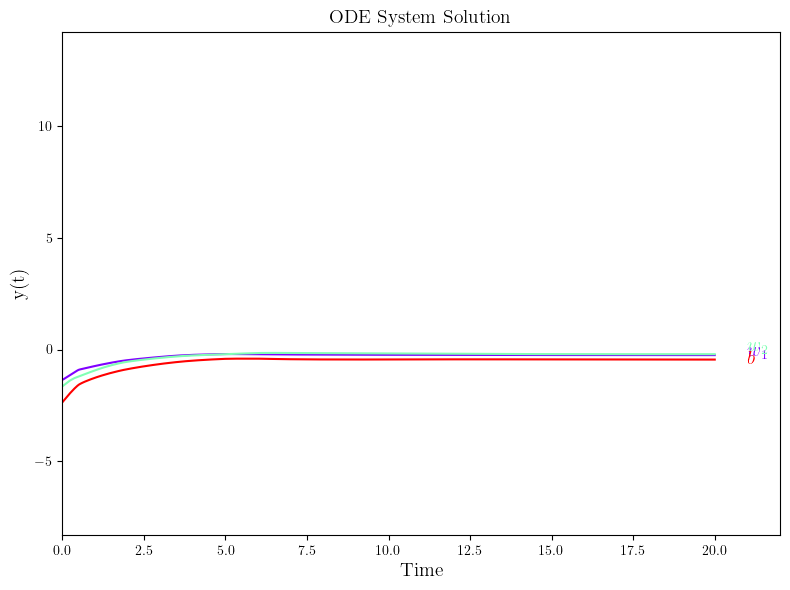

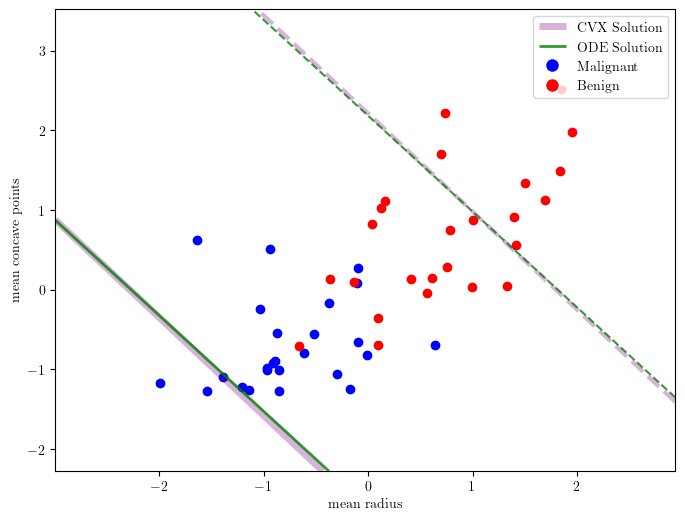

epsilon: inf time: 3657.9990541934967 iterations: 10000


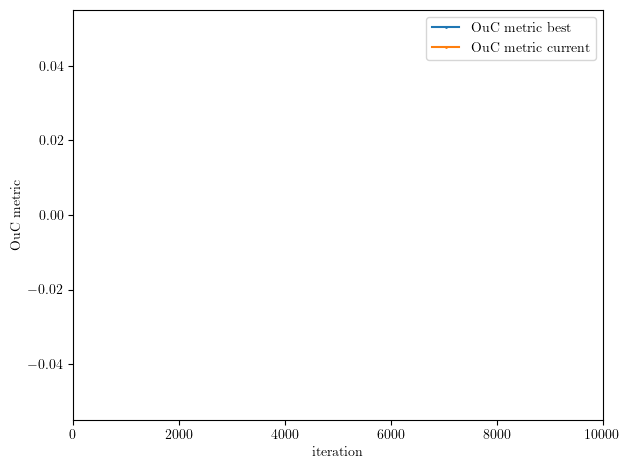

Last losses: [3.632277011871338, 3.780606269836426, 3.8032736778259277, 3.4957194328308105, 3.3305864334106445, 2.90826153755188, 2.7020206451416016, 2.223161220550537, 1.722271203994751, 1.4021553993225098]


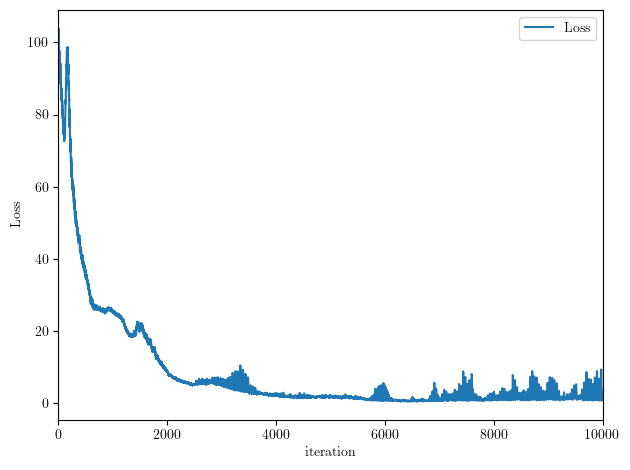

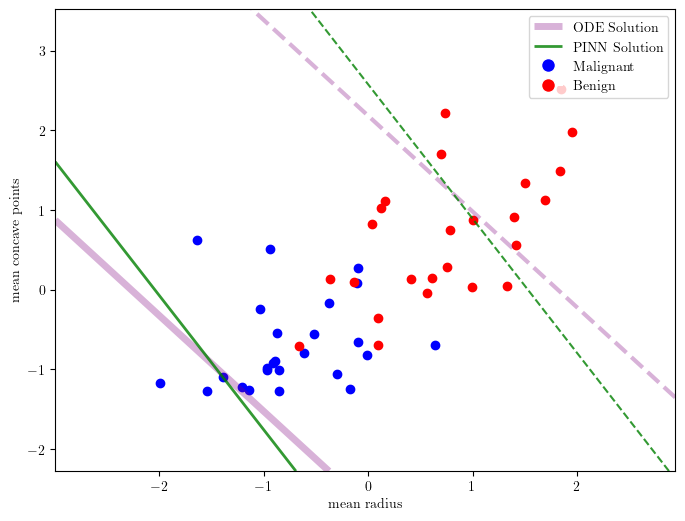

Variables: [-0.27977002 -0.16608298 -0.5032042  -0.22753143 -0.42056632 -0.3705815
 -0.5367595  -0.3961135  -0.13056421 -0.6669152   0.171305   -1.2795515
  0.51840353  0.09967649  0.08173227 -0.2663951  -0.5721884   0.02719498
  0.01442462  0.02317458  0.01592809 -0.05597323  0.02519792  0.04035711
  0.01490313  0.04717058  0.03780359  0.03390661  0.040461    0.0119766
  0.01855177  0.0253976   0.04702643  0.01456743 -0.00039035  0.10248178
  0.0169189   0.08268619  0.02410233 -0.06064552  0.05033974  0.01974213
  0.00731426  0.042687    0.02410167  0.05665696  0.04603779  0.02594972
  0.0071831   0.02217525  0.02544057  0.03142124  0.02585828  0.0025422
  0.02117366  0.02609849  0.04775381  0.02097961 -0.02646402 -0.04317486
  0.02512503  0.02594292  0.0424211  -0.03940193  0.03080249  0.04200983
  0.02463776]
Constraints: [-1.7942044  -3.854062   -3.573176   -4.3974757  -0.15461282 -4.015416
 -3.0040445  -4.7142105  -0.46369594 -2.7874901  -2.808765   -3.8046927
 -2.563368   -1.2904

Time: 2.487283229827881
objective: 1.9042094 lim: 0.01
objective: 1.9042094
w:  [-0.24545822 -0.20136037 -0.44858387 -0.1972887  -0.46941543 -0.3329468
 -0.49288498 -0.41572218 -0.14474774 -0.64401846  0.17466914 -1.36850979
  0.53606021 -0.00618535  0.12138217 -0.23504514] b:  -0.5591085423734379
hyperplane similarity: 6.691857888740937e-05
Dual variables (alpha): [-0.24545822 -0.20136037 -0.44858387 -0.1972887  -0.46941543 -0.3329468
 -0.49288498 -0.41572218 -0.14474774 -0.64401846  0.17466914 -1.36850979
  0.53606021 -0.00618535  0.12138217 -0.23504514 -0.55910854 -0.00000205
 -0.00000119 -0.00000141 -0.00000143 -0.00000221 -0.00000207 -0.00000279
 -0.00000108 -0.00000289 -0.00000192 -0.00000236 -0.00000201 -0.00000141
 -0.00000142 -0.0000096  -0.00000212  0.00000256 -0.00060941  0.00000011
 -0.00000129 -0.00000148 -0.00000141 -0.00000515 -0.00044524 -0.00000143
  0.00184236 -0.00000177 -0.00000004 -0.000003    0.0012711  -0.00000153
 -0.00000238 -0.00000396 -0.00000236 -0.00000196 

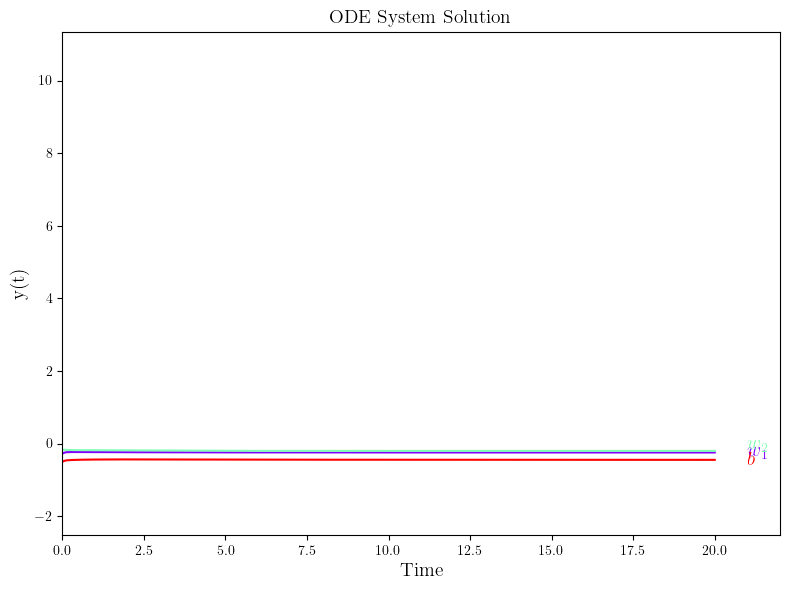

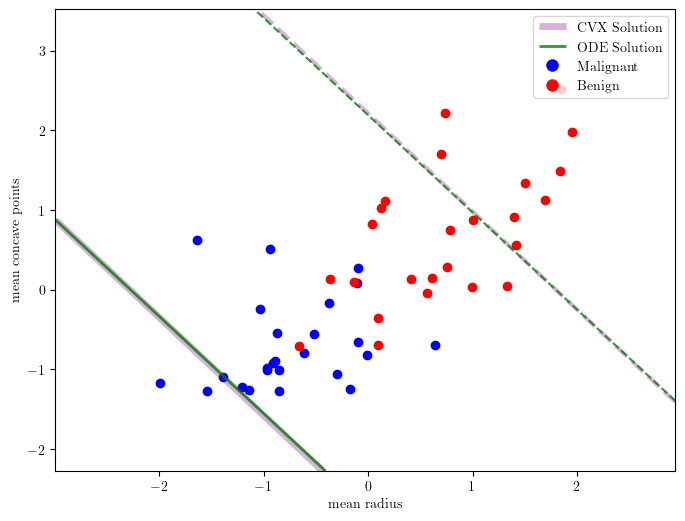

epsilon: inf time: 4014.5010623931885 iterations: 10000


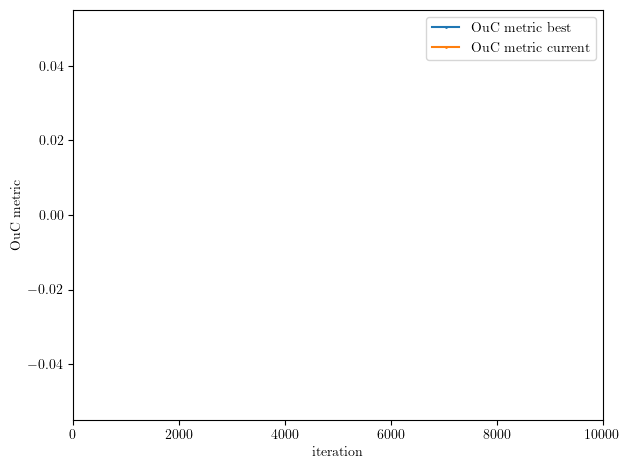

Last losses: [0.0542353093624115, 0.061646394431591034, 0.0592704713344574, 0.04911629110574722, 0.04692014306783676, 0.06557124108076096, 0.10006284713745117, 0.10275648534297943, 0.09477579593658447, 0.07586168497800827]


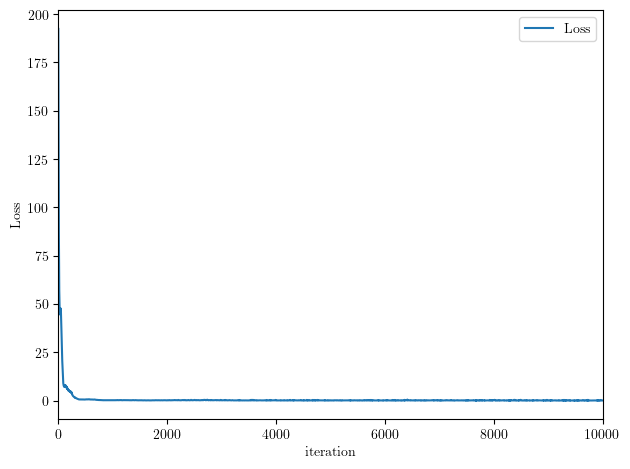

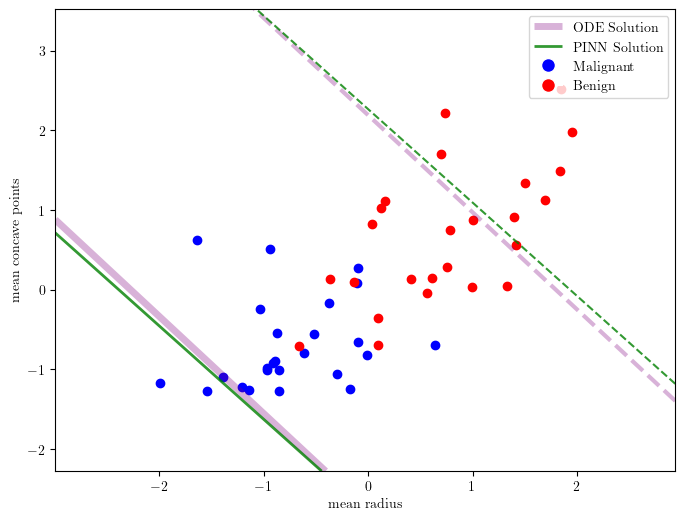

Variables: [-0.23131701 -0.19738874 -0.43882298 -0.18796137 -0.47868544 -0.32708445
 -0.4815173  -0.4097511  -0.14711283 -0.64447945  0.16384399 -1.3614174
  0.5327167   0.0059256   0.11336243 -0.23164368 -0.55295825 -0.01152615
 -0.00316564 -0.00558587  0.00600158  0.01064818  0.00707015 -0.00054616
  0.01110742 -0.01009052 -0.01102155  0.00067878  0.00434716  0.00638404
 -0.00912821 -0.01618253 -0.00098044  0.009782    0.01574229  0.00531028
 -0.00055902 -0.00689629 -0.00522891  0.00299443 -0.00916344 -0.00358056
  0.02743124 -0.00181851  0.0189888   0.00703431 -0.00392285  0.00580542
 -0.00883084  0.00144975 -0.00848949  0.00918748  0.00036759  0.00271101
 -0.00747135 -0.00977716  0.00121589 -0.00238258 -0.01115616  0.00719896
  0.01240649  0.00323197 -0.014005   -0.0052583   0.0035645  -0.00184308
  0.01105191]
Constraints: [-1.6454654  -3.7714458  -3.497522   -4.422374   -0.1577664  -3.5914872
 -3.288995   -4.525602   -0.32281545 -2.996592   -2.6987674  -3.848357
 -2.5300374  -1.1

Time: 3.0166807174682617
objective: 1.8960786 lim: 0.01
objective: 1.8960786
w:  [-0.24536932 -0.20058909 -0.4492834  -0.1971404  -0.46652531 -0.33271591
 -0.49341285 -0.4195013  -0.14503472 -0.64417091  0.17506833 -1.36958696
  0.53706828 -0.0077846   0.12133901 -0.23513305] b:  -0.5594540954623094
hyperplane similarity: 7.290760634506843e-05
Dual variables (alpha): [-0.24536932 -0.20058909 -0.4492834  -0.1971404  -0.46652531 -0.33271591
 -0.49341285 -0.4195013  -0.14503472 -0.64417091  0.17506833 -1.36958696
  0.53706828 -0.0077846   0.12133901 -0.23513305 -0.5594541  -0.00000022
  0.00000049  0.00000048 -0.00000048  0.00000014  0.00000049 -0.00000046
 -0.00000047 -0.00000044  0.00000047  0.00000047 -0.00000046 -0.00000045
  0.00000046 -0.00000007 -0.00000048 -0.0000007  -0.00074985 -0.0000048
  0.00000046 -0.0000005   0.00000047  0.00000047 -0.00030858 -0.00000048
  0.00107477  0.00000047 -0.00000047 -0.00000046  0.00085331  0.0000005
  0.00000047 -0.00000047  0.00000045 -0.00000077

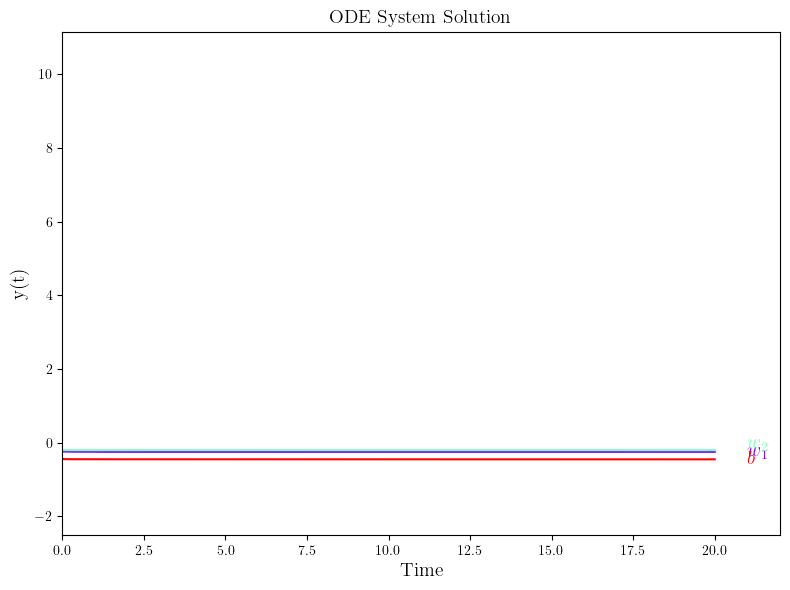

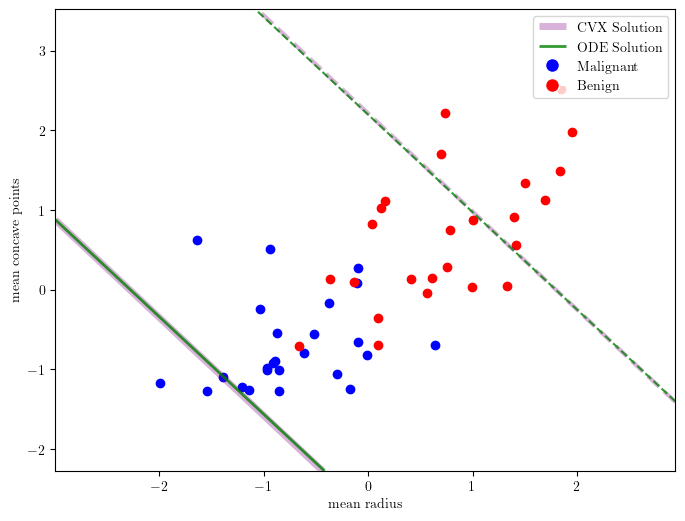

epsilon: inf time: 801.0791172981262 iterations: 1975


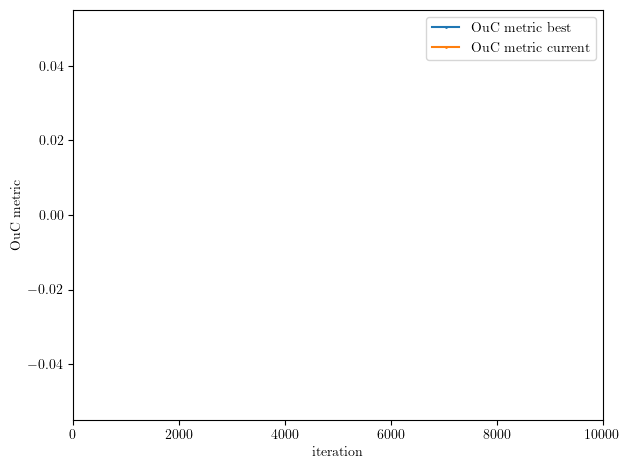

Last losses: [0.010280020534992218, 0.009407821111381054, 0.009145262651145458, 0.009094053879380226, 0.010112890042364597, 0.009081127122044563, 0.0097021060064435, 0.009310109540820122, 0.008454205468297005, 0.009795480407774448]


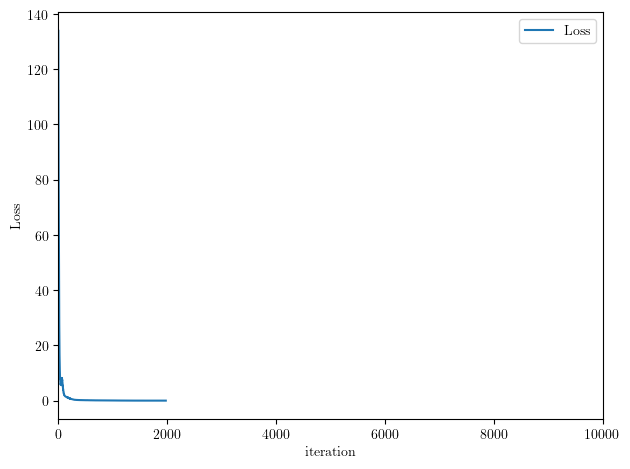

>>> NN Solution is accurate, last iteration


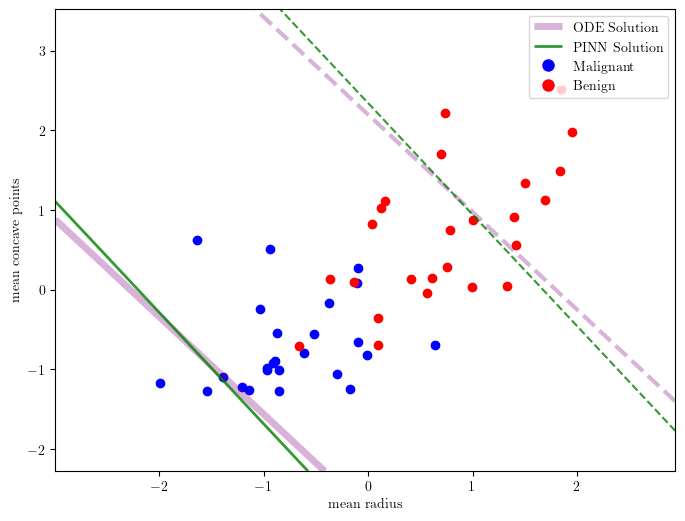

Variables: [-0.25770313 -0.18429111 -0.45979062 -0.19296752 -0.46305603 -0.32629842
 -0.4892468  -0.4010854  -0.14701521 -0.64111215  0.14476229 -1.3407402
  0.5242801  -0.00783124  0.11017504 -0.24665886 -0.5686182   0.01691078
  0.00188255 -0.00829349  0.00085898  0.00024954  0.00717463  0.00636941
  0.03005013 -0.00152562 -0.00745977  0.00684206  0.06587427 -0.01362826
 -0.00556993 -0.01531284  0.00487562  0.02733805 -0.02017737 -0.04105769
  0.00885939  0.01692677  0.00232959 -0.00225583 -0.03532552  0.0209417
  0.01801533  0.00112151 -0.01298992 -0.00177234  0.0171064   0.00418421
  0.00080317 -0.01035379  0.01432651  0.01229052 -0.05120249  0.01406557
 -0.01701595 -0.02111675 -0.03295661  0.00435734  0.00250386  0.0053779
  0.01674121  0.01612576 -0.02935212  0.01481119 -0.00203913 -0.00721513
 -0.02916978]
Constraints: [-1.7123682  -3.7972429  -3.556608   -4.451894   -0.14708926 -3.6925766
 -3.3387182  -4.609865   -0.3483187  -3.0023541  -2.7245247  -3.9369993
 -2.5564046  -1.17

In [14]:
ITERATIONS = 2000
LR = 0.01
ip = np.zeros(NY)
ip[:nw + nb] = 1.0

for i in range(8):
    print('>>>> ITERATION:', i+1)
    res, pinn_obj, lastIter = iteration(ip)
    wb_pinn = res[:nw+1]
    if lastIter:
        print('>>>> Results obtained, OuC: ', pinn_obj)
        break
    ip = res
    ITERATIONS = 10000
    LR = 0.0001